# Module 3: Exploratory Data Analysis

## Configuration

In [23]:
# basic configuration, put these lines at the top of each notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
# plotting configuration (basically just change plot size)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

In [25]:
# show all columns of our data frames
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.precision", 2)
pd.options.display.max_rows = 100

## Data loading

We have two distinct datasets which we can use for our fraud detection use case:
- Transaction data: this includes information like the target variable (fraud/no fraud) or credit card information
- Identity data: this includes information like device and operating system of the buyer

We can join both datasets using the variable `TransactionID`. More detailed information can be found on the official [competition page](https://www.kaggle.com/c/ieee-fraud-detection/data).

Firstly, let's create a symbolic link to our shared data directory, as well as a directory for storing intermediate results.

In [1]:
!pwd

/Users/felix/code/ml/ml-workflow-tools/nbs


In [2]:
!ln -s ../../shared_data data

In [3]:
!ls data

shared_data           train_identity.csv    train_transaction.csv


We can see that there are two data files inside our shared data directory. Since it is read-only, we need to create a directory for storing intermediate results.

In [4]:
!mkdir tmp

mkdir: tmp: File exists


In [5]:
!ls

02_Introduction_ML_Development.ipynb 06_Model_Evaluation.ipynb
03_Exploratory_Data_Analysis.ipynb   data
04_Feature_Engineering.ipynb         img
05_Model_Development.ipynb           tmp


Now, let's load this data into data frames, i.e., indexed tables. We can use the `pandas` package for this.

In [7]:
import pandas as pd

In [8]:
# it's a good practice to use uppercase names for constants
DATA_PATH = 'data/'
TMP_PATH = 'tmp/'
identity = pd.read_csv(f'{DATA_PATH}train_identity.csv')
transaction = pd.read_csv(f'{DATA_PATH}train_transaction.csv')

## Dataset overview

We can now take a look at the number of columns (i.e., features) and rows (i.e., examples) in both datasets.

In [9]:
print(f'Identity dataset has {identity.shape[0]} rows and {identity.shape[1]} columns.')
print(f'Transaction dataset has {transaction.shape[0]} rows and {transaction.shape[1]} columns.')

Identity dataset has 144233 rows and 41 columns.
Transaction dataset has 590540 rows and 394 columns.


Now, we can combine the two datasets using the `merge` function. Since we are primarily interested in transactions, this will be our main table. Thus, we will simply add identity information to each transaction if available. Conceptually, this is equivalent to performing a _left join_ in SQL.

In [10]:
data = pd.merge(transaction, identity, on='TransactionID', how='left')

print(f'Training dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

Training dataset has 590540 rows and 434 columns.


In order to get a first impression of our dataset, we can use `pandas`' `head` function, which prints out the first `n` rows.

In [11]:
data.head(n=10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For our subsequent steps, it's useful to know the nature of our features. With a tabular dataset like this, we mainly distinguish between *categorical* and *numerical* features. Luckily, Kaggle provides us with more information about how to treat each feature (see image and [forum post](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-607486))

<img alt="Categorical features of fraud detection dataset" src="img/kaggle_feature_information.png" style="width: 800px"/>

Let's mark all these features as categorical to derive better descriptive statistics later on. Right now, they are marked as numbers or don't have a meaningful type at all.

In [12]:
print(f'Type of target variable: {data.isFraud.dtype}')
print(f'Type of feature ProductCD: {data.ProductCD.dtype}')

Type of target variable: int64
Type of feature ProductCD: object


In [13]:
cat_feats = ['isFraud', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
             'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
             'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
             'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
             'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [14]:
for feat in cat_feats:
    data[feat] = data[feat].astype('category')

In [15]:
print(f'Type of target variable: {data.isFraud.dtype}')
print(f'Type of feature ProductCD: {data.ProductCD.dtype}')

Type of target variable: category
Type of feature ProductCD: category


Let's quickly check if the data remained unchanged.

In [16]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Now, we can take a look at the ratio of numerical and categorical features. We do this by looking at the `dtype` attribute of each column. After collecting these, we can use the `Counter` class from the standard library to derive exact counts.

In [17]:
from collections import Counter

dtypes = [data[feat].dtype.name for feat in data.columns]
c = Counter(dtypes)
type_counts = c.most_common()

for count in type_counts:
    print(f'Dataset contains {count[1]} features of type {count[0]}.')

Dataset contains 382 features of type float64.
Dataset contains 50 features of type category.
Dataset contains 2 features of type int64.


## Target variable

For our target variable (as for every categorical variable), we can look at the following aspects to get a better understanding of it:
- Number of classes
- Descriptive statistics: count & frequencies
- Plots: histogram

Let's look at all these things...

In [18]:
print(f'Target variable {data.isFraud.name} has {len(data.isFraud.dtype.categories)} classes.')

Target variable isFraud has 2 classes.


In [19]:
data.isFraud.dtype.categories

Int64Index([0, 1], dtype='int64')

In [20]:
data.isFraud.describe()

count     590540
unique         2
top            0
freq      569877
Name: isFraud, dtype: int64

In [21]:
data.isFraud.value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

Our dataset seems to be very imbalanced, i.e., one class is overrepresented. In our case, more than 96% of all transactions were not registered as fraudulent.

Alternatively to the above generated statistics, we can look at a histogram to get a first impression of our target variable.

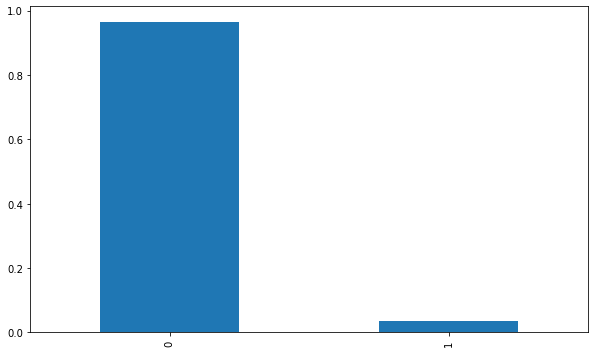

In [26]:
data.isFraud.value_counts(normalize=True).plot(kind='bar')

## Features

For our features we can look at univariate statistics, which describe characteristics of one particular feature, and bivariate statistics, which focus on relationships between features. We will start with the former part of the analysis.

### Missing values

Firstly, we should look at how much missing data we have. The `isnull` function counts missing values, as well as `NaN` values.

In [27]:
missing_vals = data.isnull().sum().sort_values(ascending=False) / len(data)
missing_vals

id_24            0.99
id_25            0.99
id_07            0.99
id_08            0.99
id_21            0.99
                 ... 
C11              0.00
C12              0.00
C13              0.00
C14              0.00
TransactionID    0.00
Length: 434, dtype: float64

We can already see that we should exclude a large percentage of our features, probably everything with more than 20% of missing values (since we have a lot of data). Additionally, we should check whether these numbers are similar for both classes. Let's put this functionality inside a function.

In [21]:
def missing_val_perc(df, levels, target=None):
    data = df
    if target is not None:
        data = data.loc[data.isFraud == target]
    missing_vals = data.isnull().sum().sort_values(ascending=False) / len(data)
    for l in levels:
        perc = len(missing_vals.loc[missing_vals > l]) / len(missing_vals)
        print('Percentage of features with more than {:.0f}% missing values: {:.1f}%'.format(l * 100, perc * 100))

In [22]:
missing_val_perc(data, levels, target=0)

Percentage of features with more than 20% missing values: 58.1%
Percentage of features with more than 50% missing values: 49.3%
Percentage of features with more than 80% missing values: 17.3%


In [23]:
missing_val_perc(data, levels, target=1)

Percentage of features with more than 20% missing values: 68.4%
Percentage of features with more than 50% missing values: 33.4%
Percentage of features with more than 80% missing values: 14.5%


The percentages are roughly equal, excluding columns should thus be no problem.

### Univariate statistics & plots

We already saw an example of how to apply the `describe` function. We can use this to get an impression of our features as well. Let's look at examples for both categorical and numerical variables.

#### Categorical variables

In [29]:
data.card4.describe()

count     588963
unique         4
top         visa
freq      384767
Name: card4, dtype: object

In [30]:
data.card4.value_counts(normalize=True)

visa                0.65
mastercard          0.32
american express    0.01
discover            0.01
Name: card4, dtype: float64

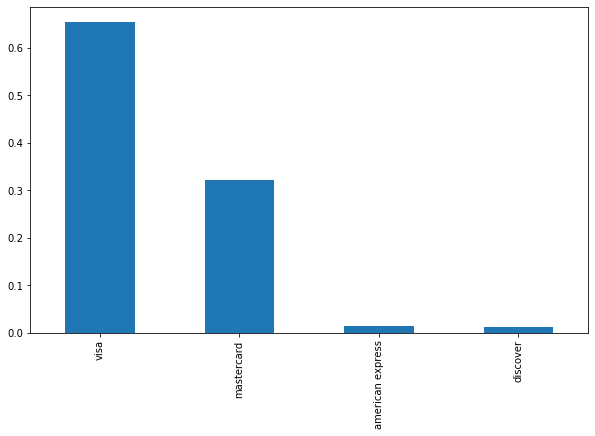

In [31]:
data.card4.value_counts(normalize=True).plot(kind='bar')

Histograms for some more interesting (and interpretable) features are shown below. Because some of the categorical variables contain a lot of classes, we will write a helper function that plots only the top ten items.

In [33]:
def plot_top_ten(col):
    counts = col.value_counts(normalize=True)
    top_ten = counts.head(10)
    top_ten.plot(kind='bar', title=col.name)
    plt.show()

**Exercise:** Describe the variables `card6` and `P_emaildomain` using descriptive statistics and visualizations.

#### Numerical variables

The `describe` function also works for numerical variables. It will offer us basic statistics like the mean, standard deviation and quantiles of a particular column. Let's look at the purchase amount first, which is stored in the `TransactionAmt` column.

In [35]:
data.TransactionAmt.describe()

count    590540.00
mean        135.03
std         239.16
min           0.25
25%          43.32
50%          68.77
75%         125.00
max       31937.39
Name: TransactionAmt, dtype: float64

In [36]:
def plot_bins(col, bins, labels):
    bins = pd.cut(col, bins, labels=labels).value_counts(normalize=True)
    bins.plot(kind='bar', title=col.name)
    plt.show()

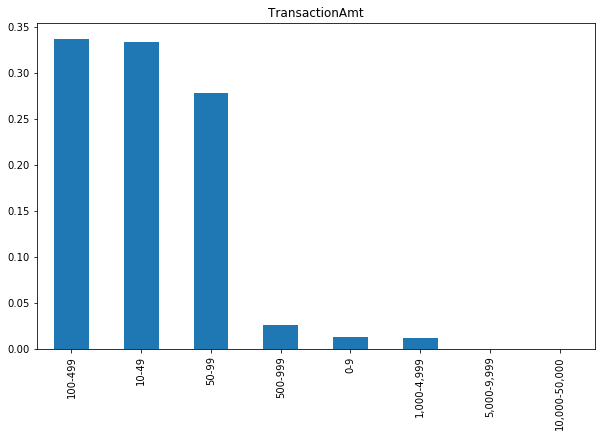

In [37]:
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
labels = ['0-9', '10-49', '50-99', '100-499', '500-999', '1,000-4,999', '5,000-9,999', '10,000-50,000']

plot_bins(data.TransactionAmt, bins, labels)

We could repeat this process for the other numerical variables (and you **should** definitely do that for your own data!), but since this is a Kaggle competition most of the features are anonymized and thus not very interpretable.

**Exercise:** Describe the variables `dist1` and `dist2` using descriptive statistics and visualizations.

### Bivariate statistics & plots

After looking at some univariate statistics, we can now go on to examine bivariate relationships within our data. Here, we will mainly look at correlation statistics between features (and the target variable) and create some plots that might give us intuitions about relationships within our dataset.

Since we have two variable types (categorical & numerical), we have to account for three relationship types:
- numerical-numerical
- categorical-categorical
- categorical-numerical

Let's start with the first one.

#### Two numerical variables

Let's look at `TransactionAmt` and `TransactionDT`, since we can interpret these features.

In [38]:
df = data[['TransactionAmt', 'TransactionDT']].dropna()
df.shape

(590540, 2)

We can subtract the minimum from all datetimes to get more meaningful data.

In [39]:
df['TransactionDT'] = df['TransactionDT'] - df['TransactionDT'].min()
df.head(n=10)

,TransactionAmt,TransactionDT
0,68.5,0
1,29.0,1
2,59.0,69
3,50.0,99
4,50.0,106
5,49.0,110
6,159.0,122
7,422.5,129
8,15.0,135
9,117.0,136


Now, we can calculate the correlation coefficient and create some plots.

In [40]:
df.corr()

,TransactionAmt,TransactionDT
TransactionAmt,1.00,0.01
TransactionDT,0.01,1.00


In [41]:
df_sample = df.sort_values('TransactionDT').sample(1000)

,TransactionAmt,TransactionDT
522773,117.00,13643700
28598,25.00,645676
372702,117.00,9200778
83953,1000.00,1708054
337482,107.95,8209998
87818,27.00,1776388
185072,477.95,4035787
250478,54.50,5876954
420079,34.00,10541069
389519,42.95,9676741


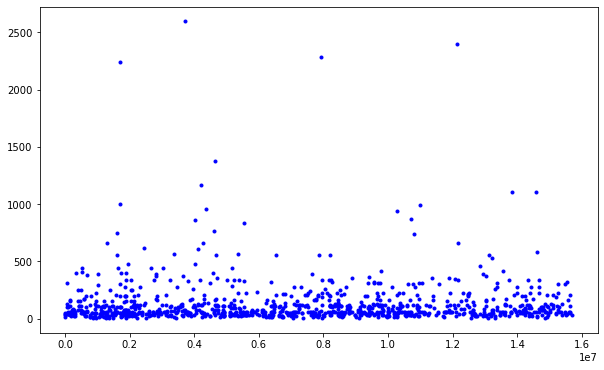

In [42]:
plt.plot(df_sample.TransactionDT, df_sample.TransactionAmt, 'b.')
plt.show()

As expected, there is no pattern to exploit for the transaction date, as indicated by the correlation coefficient (0.01) and visual inspection of the plot.

**Exercise:** Examine the relationship between the variables `TransactionAmt` and `dist1`/`dist2` using the outlined process.

#### Two categorical variables

For two categorical variables, we can create matrices based on value counts and stacked bar charts. As an example, let's look at the relationship between credit card company and fraudulence.

In [43]:
def plot_fraud_percentage_per_class(data, col, return_df=False):
    # extract and aggregate necessary data
    counts = data[[col, 'isFraud']].dropna().groupby([col, 'isFraud']).size()
    index = []
    percs = []
    # calculate fraud/no fraud percentages and save in data frame
    for level in counts.index.levels[0]:
        level_counts = counts[level]
        no_fraud = level_counts.iloc[0] / level_counts.sum()
        fraud = 0
        if len(level_counts) > 1:
            fraud = level_counts.iloc[1] / level_counts.sum()
        percs.append((fraud, no_fraud))
        index.append(level)
    df = pd.DataFrame(columns=['fraud', 'no_fraud'], index=index, data=percs)
    plt.bar(df.index, df.fraud, width=0.4)
    plt.xlabel(col)
    plt.ylabel('fraud percentage')
    plt.show()
    if return_df:
        return df

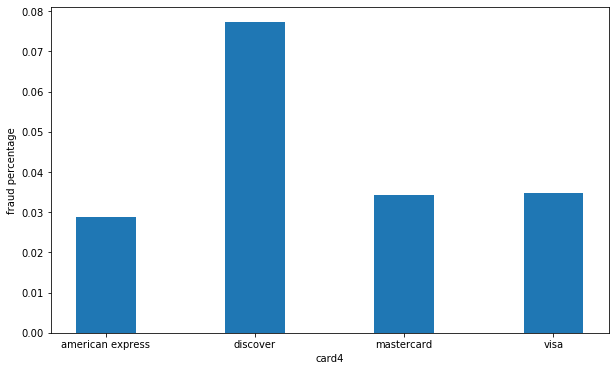

In [44]:
df = plot_fraud_percentage_per_class(data, 'card4', return_df=True)
df

We can see that fraudulent activity is far more common for credit card company "Discover". This could be a valuable insight in model building. Let's plot this for some more variables.

**Exercise:** Examine fraud percentages for the variables `card6` and `DeviceType`.

#### One numerical, one categorical variable

If we are looking at one numerical and one categorical variable, we can for example examine descriptive statistics per class. Let's write a function that aggregates numerical data and creates a DataFrame containing the mean, median and standard deviation for each class.

In [47]:
def plot_mean_per_class(data, cat, num, return_df=False):
    df = data[[cat, num]].groupby(cat).agg(['mean', 'std', 'median'])
    df[(num, 'mean')].plot(kind='bar')
    plt.show()
    if return_df:
        return df

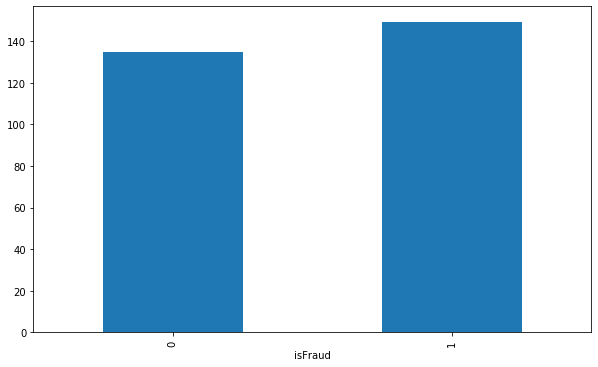

In [48]:
df = plot_mean_per_class(data, 'isFraud', 'TransactionAmt', return_df=True)

In [49]:
df

TransactionAmt               
                  mean     std median
isFraud                              
0               134.51  239.40   68.5
1               149.24  232.21   75.0

We can now reuse this function to generate some more plots.

**Exercise:** Examine the relationships of the following variable pairs:
- `DeviceType` and `TransactionAmt`
- `card4` and `TransactionAmt`
- `card6` and `TransactionAmt`

## Save progress

To conclude this part of the ML workflow, let's save our data to a CSV file for later use. We will also look at the file size in order to compare it to the following steps in our workflow.

In [52]:
data.to_csv(f'{TMP_PATH}data_raw.csv')

In [48]:
!ls -lh tmp/

total 6494984
-rw-r--r--  1 felix  staff   697M Aug 26 15:10 data_raw.csv
-rw-r--r--  1 felix  staff   1.8G Aug 28 09:53 data_raw.feather
-rwxr-xr-x@ 1 felix  staff    25M Aug 16 09:26 train_identity.csv
-rwxr-xr-x@ 1 felix  staff   652M Aug 16 09:26 train_transaction.csv
